In [1]:
from cv2 import imread, imwrite
from pyFusion.fusion import Fusion

import matplotlib.pyplot as plt


In [2]:

# Parse arguments
images = ['images/MRI-CT/mr.png', 'images/MRI-CT/ct.png']
output = 'results/MRI-CT/'

# Read images
input_images = []
for image in images:
    input_images.append(imread(image))

In [3]:

from pyFusion.vgg19 import VGG19
from pyFusion.squeezeNet import Squeeze
from torch import device
from torch.cuda import is_available
# Compute fusion image

device = device("cuda" if is_available() else "cpu")
model = VGG19(device)
#model = Squeeze(device)

FU = Fusion(input_images, model)
fused_image = FU.fuse()

/mnt/0CDA4207DA41EE10/Cristian/GitHub/Tesi/VirtualEnv/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


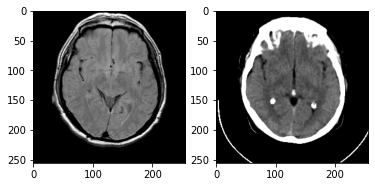

In [7]:

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(input_images[0])
ax2.imshow(input_images[1])

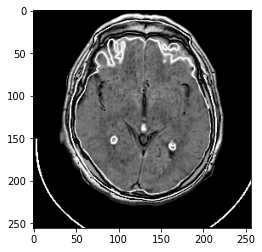

In [5]:
#imwrite("fusion", fused_image.astype('uint8'))
plt.imshow(fused_image, cmap='gray')